# Tutorial 5.1: Inception, ResNet and DenseNet

In this tutorial, we will implement and discuss variants of modern CNN architectures.

We use PyTorch Lightning for the first time here.

In [37]:
USE_NOTEBOOK = True
TEST_NOTEBOOK = False
TRAIN_GOOGLENET = False
TRAIN_RESNET = True
TRAIN_DENSENET = True

## Standard libraries
import os
import json
import math
import numpy as np 
import scipy.linalg
import random
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
if USE_NOTEBOOK:
    %matplotlib inline 
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('svg', 'pdf') # For export
    from matplotlib.colors import to_rgb
    import matplotlib
    matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
# from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateLogger, ModelCheckpoint

if USE_NOTEBOOK:
    # Tensorboard extension (for looking at tensorboard inside jupyter notebook)
    from torch.utils.tensorboard import SummaryWriter
    %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial5"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Throughout this tutorial, we use the CIFAR dataset. (We can change the dataset if necessary)

In [38]:
# Transformations applied on each image => make them a tensor and normalize
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      # transforms.RandomCrop(32,4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


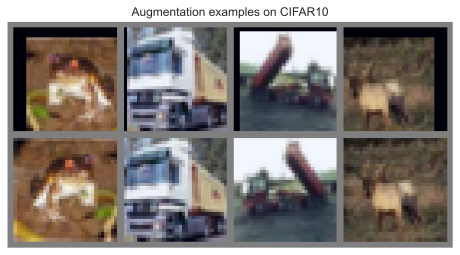

In [39]:
if USE_NOTEBOOK:
    NUM_IMAGES = 4
    images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
    orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
    orig_images = [test_transform(img) for img in orig_images]

    img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(8,8))
    plt.title("Augmentation examples on CIFAR10")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

## PyTorch Lightning

In [4]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "gelu": nn.GELU
}

In [5]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, "Unknown model name \"%s\". Available models are: %s" % (model_name, str(model_dict.keys()))

In [6]:
class CIFARTrainer(pl.LightningModule):
    
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        super().__init__()
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)
    
    
    def forward(self, imgs):
        return self.model(imgs)
    
    
    def configure_optimizers(self):
        if self.hparams.optimizer_name == "Adam":
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, "Unknown optimizer: \"%s\"" % self.hparams.optimizer_name
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=True, on_epoch=False)
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        TP = (preds.argmax(dim=-1) == labels).sum()
        count = preds.shape[0]
        return {"TP": TP, "count": count}
        
    
    def validation_epoch_end(self, batch_parts):
        TP = sum([b["TP"] for b in batch_parts])
        count = sum([b["count"] for b in batch_parts])
        acc = TP.float()/count
        self.log('val_acc', acc)
        
        
    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        
        result = pl.EvalResult()
        result.log('test_acc', acc)
        return result

In [7]:
def train_model(model_name, save_name=None, **kwargs):
    if save_name is None:
        save_name = model_name
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),
                         checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                         gpus=1,
                         max_epochs=180 if not TEST_NOTEBOOK else 1,
                         callbacks=[LearningRateLogger("epoch")],
                         progress_bar_refresh_rate=0 if not USE_NOTEBOOK else 1)
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = CIFARTrainer.load_from_checkpoint(pretrained_filename)
    else:
        model = CIFARTrainer(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    print("Test result", test_result)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    return model, result

## Inception

In [8]:
class InceptionBlock(nn.Module):
    
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        super().__init__()
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )
        
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )
        
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )
        
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )
        
    
    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [9]:
class GoogleNet(nn.Module):
    
    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = {"num_classes": num_classes, "act_fn": act_fn_by_name[act_fn_name]}
        self._create_network()
    
    
    def _create_network(self):
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams["act_fn"]()
        )
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3":32,"5x5":16}, c_out={"1x1":16,"3x3":32,"5x5":8,"max":8}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(64, c_red={"3x3":32,"5x5":16}, c_out={"1x1":24,"3x3":48,"5x5":12,"max":12}, act_fn=self.hparams["act_fn"]),
            nn.MaxPool2d(3, stride=2, padding=1),
            InceptionBlock(96, c_red={"3x3":32,"5x5":16}, c_out={"1x1":24,"3x3":48,"5x5":12,"max":12}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(96, c_red={"3x3":32,"5x5":16}, c_out={"1x1":16,"3x3":48,"5x5":16,"max":16}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(96, c_red={"3x3":32,"5x5":16}, c_out={"1x1":16,"3x3":48,"5x5":16,"max":16}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(96, c_red={"3x3":32,"5x5":16}, c_out={"1x1":32,"3x3":48,"5x5":24,"max":24}, act_fn=self.hparams["act_fn"]),
            nn.MaxPool2d(3, stride=2, padding=1),
            InceptionBlock(128, c_red={"3x3":48,"5x5":16}, c_out={"1x1":32,"3x3":64,"5x5":16,"max":16}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(128, c_red={"3x3":48,"5x5":16}, c_out={"1x1":32,"3x3":64,"5x5":16,"max":16}, act_fn=self.hparams["act_fn"])
        )
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams["num_classes"])
        )
    
    
    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [10]:
model_dict["GoogleNet"] = GoogleNet

In [11]:
if TRAIN_GOOGLENET:
    googlenet_model, googlenet_results = train_model(model_name="GoogleNet", 
                                                     model_hparams={"num_classes": 10, 
                                                                    "act_fn_name": "relu"}, 
                                                     optimizer_name="Adam",
                                                     optimizer_hparams={"lr": 1e-3,
                                                                        "weight_decay": 1e-4},)
else:
    googlenet_results = {}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | GoogleNet        | 260 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
I1013 13:37:12.391427 140169333622592 lightning.py:1215] 
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | GoogleNet        | 260 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        


Test result [{'test_acc': 0.5464000105857849}]


In [12]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.5464000105857849, 'val': 0.5526000261306763}


## ResNet

In [13]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        super().__init__()
        if not subsample:
            c_out = c_in
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out)
        )
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

        
    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        z = z + x
        out = self.act_fn(z)
        return out

In [14]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        super().__init__()
        if not subsample:
            c_out = c_in
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None
        self.act_fn = act_fn()

        
    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

In [15]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock
}

In [45]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, c_hidden=[16,32,64], num_blocks=[3,3,3], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = {"num_classes": num_classes, 
                        "c_hidden": c_hidden, 
                        "num_blocks": num_blocks, 
                        "act_fn": act_fn_by_name[act_fn_name],
                        "block_class": resnet_blocks_by_name[block_name]}
        self._create_network()

        
    def _create_network(self):
        c_hidden = self.hparams["c_hidden"]
        if self.hparams["block_class"] == PreActResNetBlock:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams["act_fn"]()
            )
        blocks = []
        for block_idx, block_count in enumerate(self.hparams["num_blocks"]):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0)
                blocks.append(
                    self.hparams["block_class"](c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                                act_fn=self.hparams["act_fn"],
                                                subsample=subsample,
                                                c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams["num_classes"])
        )

        
    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [46]:
model_dict["ResNet"] = ResNet

In [48]:
if TRAIN_RESNET:
    resnet_model, resnet_results = train_model(model_name="ResNet", 
                                               model_hparams={"num_classes": 10,
                                                              "c_hidden": [16,32,64,64],
                                                              "num_blocks": [3,3,3,3],
                                                              "act_fn_name": "relu"},
                                               optimizer_name="Adam",
                                               optimizer_hparams={"lr": 1e-3,
                                                                  "weight_decay": 1e-4})
else:
    resnet_results = {}

GPU available: True, used: True
I1013 17:13:42.144692 140169333622592 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1013 17:13:42.147295 140169333622592 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1013 17:13:42.149436 140169333622592 accelerator_connector.py:333] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 508 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
I1013 17:13:42.736385 140169333622592 lightning.py:1215] 
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 508 K  | [1, 3, 32, 32] | [1, 10]  
1 | lo


Test result [{'test_acc': 0.8281999826431274}]


In [19]:
print("ResNet results", resnet_results)

ResNet results {'test': 0.5647000074386597, 'val': 0.5619999766349792}


In [20]:
if TRAIN_RESNET:
    preact_resnet_model, preact_resnet_results = train_model(model_name="ResNet", 
                                                             model_hparams={"num_classes": 10,
                                                                            "c_hidden": [16,32,64],
                                                                            "num_blocks": [3,3,3],
                                                                            "act_fn_name": "relu",
                                                                            "block_name": "PreActResNetBlock"}, 
                                                             optimizer_name="Adam",
                                                             optimizer_hparams={"lr": 1e-3,
                                                                                "weight_decay": 1e-4},
                                                             save_name="PreActResNet")
else:
    preact_resnet_results = {}

GPU available: True, used: True
I1013 13:38:01.290454 140169333622592 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1013 13:38:01.292128 140169333622592 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1013 13:38:01.293474 140169333622592 accelerator_connector.py:333] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 272 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
I1013 13:38:03.329715 140169333622592 lightning.py:1215] 
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 272 K  | [1, 3, 32, 32] | [1, 10]  
1 | lo

Test result [{'test_acc': 0.5250999927520752}]


In [21]:
print("Pre-Activated ResNet", preact_resnet_results)

Pre-Activated ResNet {'test': 0.5250999927520752, 'val': 0.5296000242233276}


In [22]:
if TRAIN_RESNET:
    resnet_model, resnet_results = train_model(model_name="ResNet", 
                                               model_hparams={"num_classes": 10,
                                                              "c_hidden": [16,32,64],
                                                              "num_blocks": [3,3,3],
                                                              "act_fn_name": "relu"}, 
                                               optimizer_name="SGD",
                                               optimizer_hparams={"lr": 0.1,
                                                                  "momentum": 0.9,
                                                                  "weight_decay": 1e-4})
else:
    resnet_results = {}

GPU available: True, used: True
I1013 13:38:15.477363 140169333622592 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1013 13:38:15.478763 140169333622592 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1013 13:38:15.479886 140169333622592 accelerator_connector.py:333] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 273 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
I1013 13:38:15.881512 140169333622592 lightning.py:1215] 
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 273 K  | [1, 3, 32, 32] | [1, 10]  
1 | lo

Test result [{'test_acc': 0.30790001153945923}]


In [23]:
print("Resnet results", resnet_results)

SGD Resnet results {'test': 0.30790001153945923, 'val': 0.31279999017715454}


## DenseNet

In [24]:
class DenseLayer(nn.Module):
    
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
            bn_size - Bottleneck size (factor of growth rate)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

In [25]:
class DenseBlock(nn.Module):
    
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate,
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.block(x)
        return out

In [26]:
class ReductionLayer(nn.Module):
    
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.reduction = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.reduction(x)

In [27]:
class DenseNet(nn.Module):
    
    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = {"num_classes": num_classes,
                        "num_layers": num_layers,
                        "bn_size": bn_size,
                        "growth_rate": growth_rate,
                        "act_fn": act_fn_by_name[act_fn_name]}
        self._create_network()
        
    def _create_network(self):
        c_hidden = self.hparams["growth_rate"] * self.hparams["bn_size"]
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams["num_layers"]):
            blocks.append( 
                DenseBlock(c_in=c_hidden, 
                           num_layers=num_layers, 
                           bn_size=self.hparams["bn_size"],
                           growth_rate=self.hparams["growth_rate"],
                           act_fn=self.hparams["act_fn"])
            )
            c_hidden = c_hidden + num_layers * self.hparams["growth_rate"]
            if block_idx < len(self.hparams["num_layers"])-1:
                blocks.append(
                    ReductionLayer(c_in=c_hidden,
                                   c_out=c_hidden // 2,
                                   act_fn=self.hparams["act_fn"]))
                c_hidden = c_hidden // 2
                
        self.blocks = nn.Sequential(*blocks)
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden),
            self.hparams["act_fn"](),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams["num_classes"])
        )
        
    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [28]:
model_dict["DenseNet"] = DenseNet

In [29]:
if TRAIN_DENSENET:
    densenet_model, densenet_results = train_model(model_name="DenseNet", 
                                                   model_hparams={"num_classes": 10,
                                                                  "num_layers": [6,6,6,6],
                                                                  "bn_size": 2,
                                                                  "growth_rate": 16,
                                                                  "act_fn_name": "relu"}, 
                                                   optimizer_name="Adam",
                                                   optimizer_hparams={"lr": 1e-3,
                                                                      "weight_decay": 1e-4})
else:
    densenet_results = {}

GPU available: True, used: True
I1013 13:38:27.241151 140169333622592 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1013 13:38:27.242077 140169333622592 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1013 13:38:27.242639 140169333622592 accelerator_connector.py:333] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | DenseNet         | 239 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
I1013 13:38:32.331611 140169333622592 lightning.py:1215] 
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | DenseNet         | 239 K  | [1, 3, 32, 32] | [1, 10]  
1 | lo

Test result [{'test_acc': 0.6050000190734863}]


In [30]:
print(densenet_results)

{'test': 0.6050000190734863, 'val': 0.6050000190734863}


In [31]:
# model = model_dict["ResNet"](efficient_blocks=True)
# print("Number of parameters", sum([np.prod(p.shape) for p in model.parameters()]))
# print("Parameter count per weights", "\n".join(["%s: %i (%s)" % (n, np.prod(p.shape), str([e for e in p.shape])) for n, p in model.named_parameters()]))